<a href="https://colab.research.google.com/github/aaronmj7/Transfer_learning_assignment/blob/main/Transfer_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Image Classification

By Aaron Modiyil Joseph

22018497

In [ ]:
# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.utils import set_random_seed, plot_model
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Set random seed to get same result each time
set_random_seed(1)

# Set seaborn theme for better looking plots
sns.set_theme(context='paper', color_codes=True)

In [ ]:
# Define necessary functions
def plot_loss_accuracy(history):
    """
    Plots Loss and Accuracy plots.

    Parameters:
    - history: history object returned by model.fit

    Returns:
    - figure and list of axes
    """
    # Get loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Create range for epochs
    epochs = range(1, len(loss) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(10,6))

    # Plot training and validation loss
    axs[0].plot(epochs, loss, color='royalblue', label='Training')
    axs[0].plot(epochs, val_loss, color='orangered', label='Validation')
    axs[0].set_xticks([num for num in epochs if num % 2 == 0])
    axs[0].set_xlabel('Number of Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Model Loss')
    axs[0].legend()

    # Plot training and validation accuracy
    axs[1].plot(epochs, acc, color='royalblue', label='Training')
    axs[1].plot(epochs, val_acc, color='orangered', label='Validation')
    axs[1].set_xticks([num for num in epochs if num % 2 == 0])
    axs[1].set_xlabel('Number of Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Model Accuracy')
    axs[1].legend()


    return fig, axs

# Data Loading and Exploratory Data Analysis

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract the train dataset from Google Drive
zip_df = zipfile.ZipFile("/content/drive/MyDrive/cats_vs_dogs/train.zip", 'r')
zip_df.extractall("/content/dataset/")
zip_df.close()

In [ ]:
# Define directory for the train dataset
original_dataset_dir = '/content/dataset/train'

# Define base directory for the new dataset
base_dir = '/content/dataset/catVsdog'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [ ]:
# Define directories for training, validation and test datasets
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
  os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
  os.mkdir(validation_dir)

# Define directories for cat and dog images in the training dataset
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
  os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
  os.mkdir(train_dogs_dir)

# Define directories for cat and dog images in the validation dataset
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
  os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
  os.mkdir(validation_dogs_dir)

In [ ]:
# Copy the first 10,000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy the next 2,500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(10000, 12500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy the first 10,000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy the next 2,500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(10000, 12500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
# Check number of images in each directory
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 10000
total training dog images: 10000
total validation cat images: 2500
total validation dog images: 2500


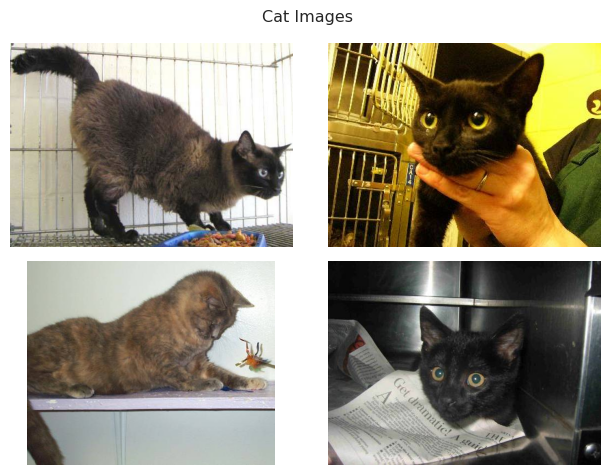

In [ ]:
# Select the first 4 cat images
img_files_cats = [f for f in os.listdir(train_cats_dir)][:4]

# Plot each cat image
for i, img_file in enumerate(img_files_cats):
    img_path = os.path.join(train_cats_dir, img_file)
    img = mpimg.imread(img_path)

    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle('Cat Images')
plt.tight_layout()
plt.savefig('cat_images.png', dpi=300, bbox_inches="tight")
plt.show()

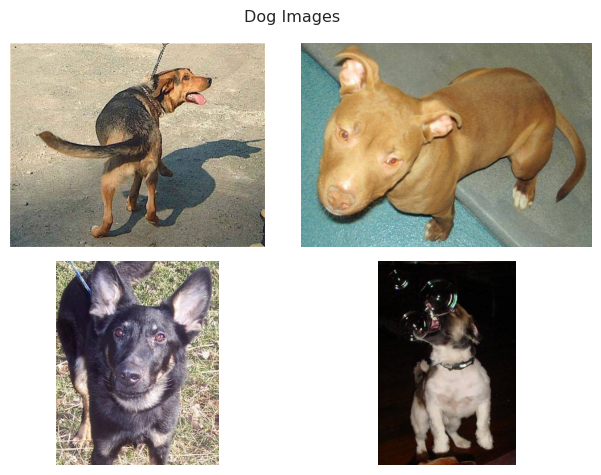

In [ ]:
# Select the first 4 dog images
img_files_dogs = [f for f in os.listdir(train_dogs_dir)][:4]

# plot each dog image in a subplot
for i, img_file in enumerate(img_files_dogs):
    img_path = os.path.join(train_dogs_dir, img_file)
    img = mpimg.imread(img_path)

    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle('Dog Images')
plt.tight_layout()
plt.savefig('dog_images', dpi=300, bbox_inches="tight")
plt.show()

# Preprocess Data

In [ ]:
# Define ImageDataGenerator for data augmentation
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                                rotation_range=50,
                                                width_shift_range=0.2,
                                                height_shift_range=0.2,
                                                shear_range=0.25,
                                                zoom_range=0.2,
                                                horizontal_flip=True,
                                                fill_mode='nearest')

# Load images from the training directory
train_generator = train_datagen_augmentation.flow_from_directory(train_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='binary')

# Define ImageDataGenerator for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load images from the validation directory
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


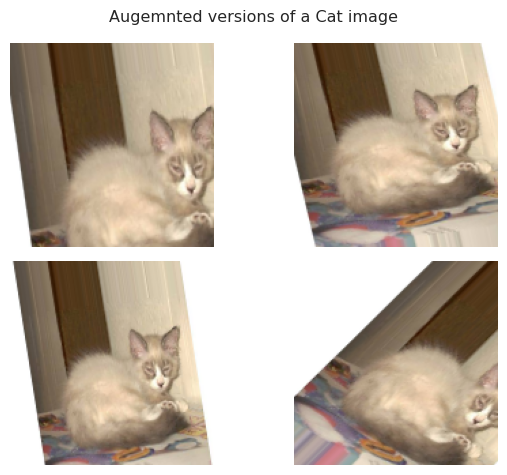

In [ ]:
# Load a cat image for visualization
fname_cat = [os.path.join(train_cats_dir, fname)
             for fname in os.listdir(train_cats_dir)]
img_path = fname_cat[20]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

# Generate and display augmented versions of the image
i = 0
plt.figure()
for batch in train_datagen_augmentation.flow(x, batch_size=1):
    plt.subplot(2, 2, i + 1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    plt.axis('off')
    i += 1
    if i % 4 == 0:
        break
plt.suptitle('Augemnted versions of a Cat image')
plt.tight_layout()
plt.show()

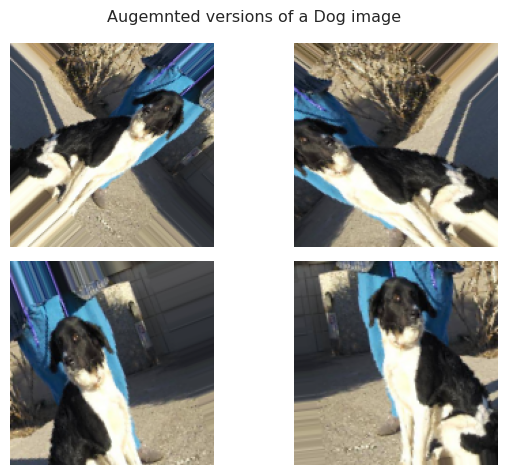

In [ ]:
# Load a dog image for visualization
fname_dog = [os.path.join(train_dogs_dir, fname)
             for fname in os.listdir(train_dogs_dir)]
img_path = fname_dog[20]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

# Generate and display augmented versions of the image
i = 0
plt.figure()
for batch in train_datagen_augmentation.flow(x, batch_size=1):
    plt.subplot(2, 2, i + 1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    plt.axis('off')
    i += 1
    if i % 4 == 0:
        break
plt.suptitle('Augemnted versions of a Dog image')
plt.tight_layout()
plt.show()

# Build the Model

In [ ]:
# Load the VGG16 model
vgg16 = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Display the architecture of the VGG16 model
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Freeze the VGG16 model for transfer learning
vgg16.trainable = False

In [ ]:
# Build the transfer learning model
tl_model = Sequential()
tl_model.add(vgg16)
tl_model.add(layers.Flatten(name='flatten_1'))
tl_model.add(layers.Dense(512, activation='relu', name='dense_1'))
tl_model.add(layers.Dense(1, activation='sigmoid', name='output_layer'))
tl_model._name = 'transfer_learning_model'

# Compile the model
tl_model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=1e-4),
            metrics=['accuracy'])

# Display the architecture of the model
tl_model.summary()

Model: "transfer_learning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               4194816   
                                                                 
 output_layer (Dense)        (None, 1)                 513       
                                                                 
Total params: 18910017 (72.14 MB)
Trainable params: 4195329 (16.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Define checkpoint to save best weights
checkpoint_filepath = '/content/drive/MyDrive/tl_model_weights.h5'

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max', save_best_only=True)

In [ ]:
# Train the model
tl_history = tl_model.fit(train_generator,
                          steps_per_epoch=400,
                          epochs=20,
                          validation_data=validation_generator,
                          validation_steps=100,
                          callbacks=[checkpoint_callback])

Epoch 1/20
400/400 [==============================] - 177s 420ms/step - loss: 0.4362 - accuracy: 0.7885 - val_loss: 0.2550 - val_accuracy: 0.8906
Epoch 2/20
400/400 [==============================] - 163s 407ms/step - loss: 0.3573 - accuracy: 0.8381 - val_loss: 0.2790 - val_accuracy: 0.8804
Epoch 3/20
400/400 [==============================] - 165s 413ms/step - loss: 0.3419 - accuracy: 0.8442 - val_loss: 0.2354 - val_accuracy: 0.9038
Epoch 4/20
400/400 [==============================] - 165s 412ms/step - loss: 0.3292 - accuracy: 0.8511 - val_loss: 0.2370 - val_accuracy: 0.9006
Epoch 5/20
400/400 [==============================] - 173s 431ms/step - loss: 0.3173 - accuracy: 0.8564 - val_loss: 0.2484 - val_accuracy: 0.8950
Epoch 6/20
400/400 [==============================] - 165s 412ms/step - loss: 0.3116 - accuracy: 0.8612 - val_loss: 0.2297 - val_accuracy: 0.9070
Epoch 7/20
400/400 [==============================] - 165s 413ms/step - loss: 0.3079 - accuracy: 0.8623 - val_loss: 0.2229 -

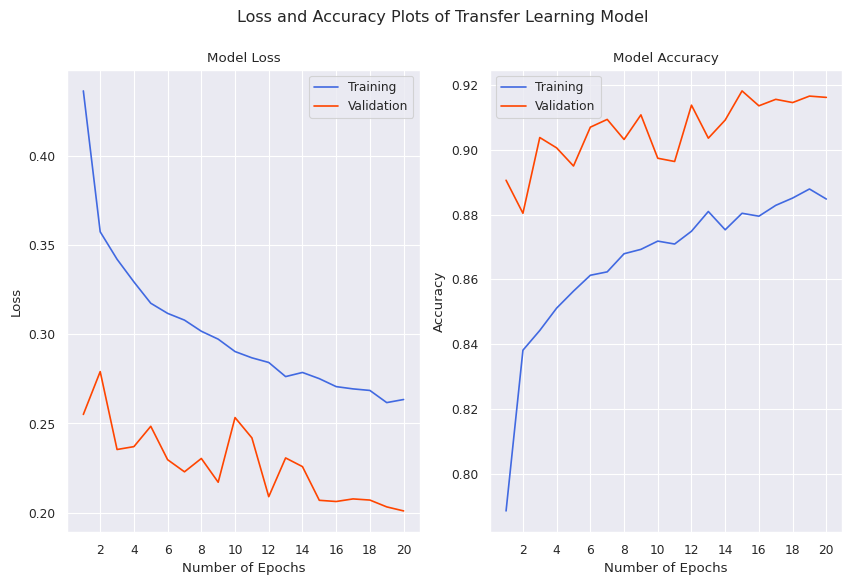

In [ ]:
# Plot model loss and accuracy
fig, axs = plot_loss_accuracy(tl_history)
fig.suptitle('Loss and Accuracy Plots of Transfer Learning Model')
plt.savefig('tl_model.png', dpi=300, bbox_inches='tight')
plt.show()

# Fine Tuning

In [ ]:
# Display the layers in VGG16 and check each are trainable or not
for i in range(len(vgg16.layers)):
  print(i, vgg16.layers[i].name, 'trainable is ', vgg16.layers[i].trainable)

0 input_1 trainable is  False
1 block1_conv1 trainable is  False
2 block1_conv2 trainable is  False
3 block1_pool trainable is  False
4 block2_conv1 trainable is  False
5 block2_conv2 trainable is  False
6 block2_pool trainable is  False
7 block3_conv1 trainable is  False
8 block3_conv2 trainable is  False
9 block3_conv3 trainable is  False
10 block3_pool trainable is  False
11 block4_conv1 trainable is  False
12 block4_conv2 trainable is  False
13 block4_conv3 trainable is  False
14 block4_pool trainable is  False
15 block5_conv1 trainable is  False
16 block5_conv2 trainable is  False
17 block5_conv3 trainable is  False
18 block5_pool trainable is  False


In [ ]:
# Unfreeze the last two blocks for fine tuning
for layer in vgg16.layers[11:]:
    layer.trainable = True
for layer in vgg16.layers[0:11]:
    layer.trainable = False

In [ ]:
# Display the layers in VGG16 and check each are trainable or not
for i in range(len(vgg16.layers)):
  print(i, vgg16.layers[i].name, 'trainable is ', vgg16.layers[i].trainable)

0 input_1 trainable is  False
1 block1_conv1 trainable is  False
2 block1_conv2 trainable is  False
3 block1_pool trainable is  False
4 block2_conv1 trainable is  False
5 block2_conv2 trainable is  False
6 block2_pool trainable is  False
7 block3_conv1 trainable is  False
8 block3_conv2 trainable is  False
9 block3_conv3 trainable is  False
10 block3_pool trainable is  False
11 block4_conv1 trainable is  True
12 block4_conv2 trainable is  True
13 block4_conv3 trainable is  True
14 block4_pool trainable is  True
15 block5_conv1 trainable is  True
16 block5_conv2 trainable is  True
17 block5_conv3 trainable is  True
18 block5_pool trainable is  True


In [ ]:
# Compile the model
tl_model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=5e-5),
            metrics=['accuracy'])

# Display the architecture of the our fine tuned model
tl_model.summary()

Model: "transfer_learning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               4194816   
                                                                 
 output_layer (Dense)        (None, 1)                 513       
                                                                 
Total params: 18910017 (72.14 MB)
Trainable params: 4195329 (16.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Define checkpoint to save best weights
checkpoint_filepath = '/content/drive/MyDrive/ft_model_weights.h5'

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max', save_best_only=True)

In [ ]:
# Train the model
ft2_history = tl_model.fit(train_generator,
                          steps_per_epoch=400,
                          epochs=20,
                          validation_data=validation_generator,
                          validation_steps=100,
                           callbacks=[checkpoint_callback])

Epoch 1/20
400/400 [==============================] - 169s 418ms/step - loss: 0.2488 - accuracy: 0.8934 - val_loss: 0.2005 - val_accuracy: 0.9180
Epoch 2/20
400/400 [==============================] - 163s 408ms/step - loss: 0.2481 - accuracy: 0.8931 - val_loss: 0.1951 - val_accuracy: 0.9194
Epoch 3/20
400/400 [==============================] - 162s 405ms/step - loss: 0.2489 - accuracy: 0.8923 - val_loss: 0.1966 - val_accuracy: 0.9182
Epoch 4/20
400/400 [==============================] - 164s 408ms/step - loss: 0.2430 - accuracy: 0.8978 - val_loss: 0.1969 - val_accuracy: 0.9196
Epoch 5/20
400/400 [==============================] - 164s 411ms/step - loss: 0.2458 - accuracy: 0.8922 - val_loss: 0.1985 - val_accuracy: 0.9200
Epoch 6/20
400/400 [==============================] - 163s 407ms/step - loss: 0.2413 - accuracy: 0.8957 - val_loss: 0.1985 - val_accuracy: 0.9192
Epoch 7/20
400/400 [==============================] - 164s 411ms/step - loss: 0.2439 - accuracy: 0.8934 - val_loss: 0.1959 -

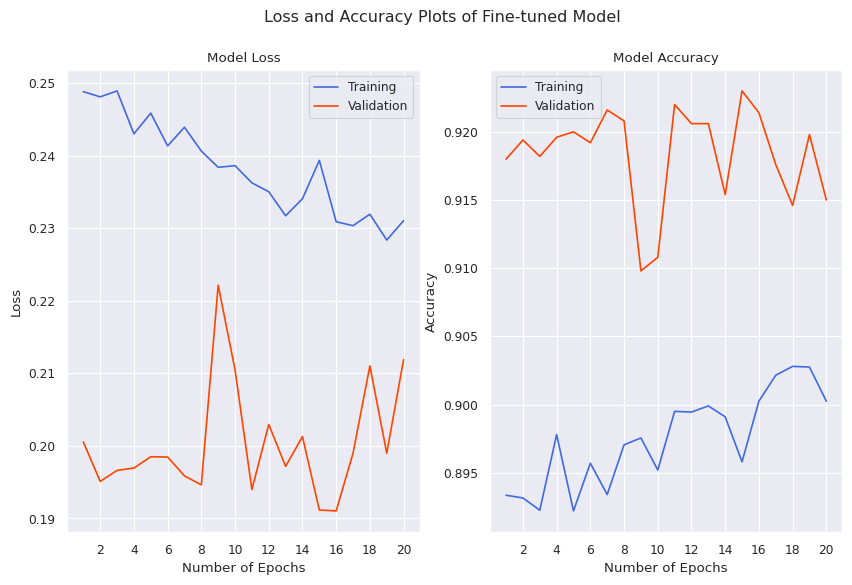

In [ ]:
# Plot model loss and accuracy
fig, axs = plot_loss_accuracy(ft2_history)
fig.suptitle('Loss and Accuracy Plots of Fine-tuned Model')
plt.savefig('ft_model.png', dpi=300, bbox_inches='tight')
plt.show()

# Training the model from scratch

In [ ]:
# Unfreeze all layers in VGG16 to train from scratch
for layer in vgg16.layers:
  layer.trainable = True

In [ ]:
# Display the layers in VGG16 and check each are trainable or not
for i in range(len(vgg16.layers)):
  print(i, vgg16.layers[i].name, 'trainable is ', vgg16.layers[i].trainable)

0 input_1 trainable is  True
1 block1_conv1 trainable is  True
2 block1_conv2 trainable is  True
3 block1_pool trainable is  True
4 block2_conv1 trainable is  True
5 block2_conv2 trainable is  True
6 block2_pool trainable is  True
7 block3_conv1 trainable is  True
8 block3_conv2 trainable is  True
9 block3_conv3 trainable is  True
10 block3_pool trainable is  True
11 block4_conv1 trainable is  True
12 block4_conv2 trainable is  True
13 block4_conv3 trainable is  True
14 block4_pool trainable is  True
15 block5_conv1 trainable is  True
16 block5_conv2 trainable is  True
17 block5_conv3 trainable is  True
18 block5_pool trainable is  True


In [ ]:
# Build the model
fs_model = Sequential()
fs_model.add(vgg16)
fs_model.add(layers.Flatten(name='flatten_1'))
fs_model.add(layers.Dense(512, activation='relu', name='dense_1'))
fs_model.add(layers.Dense(1, activation='sigmoid', name='output_layer'))
fs_model._name = 'from_scratch_model'

# Compile the model
fs_model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=1e-4),
            metrics='accuracy')

# Display the architecture of the our fine tuned model
fs_model.summary()

Model: "from_scratch_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               4194816   
                                                                 
 output_layer (Dense)        (None, 1)                 513       
                                                                 
Total params: 18910017 (72.14 MB)
Trainable params: 4195329 (16.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Define checkpoint to save best weights
checkpoint_filepath = '/content/drive/MyDrive/fs_model_weights.h5'

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max', save_best_only=True)

In [ ]:
# Train the model
fs_history = fs_model.fit(train_generator,
                          steps_per_epoch=400,
                          epochs=20,
                          validation_data=validation_generator,
                          validation_steps=100,
                          callbacks=[checkpoint_callback])

Epoch 1/20
400/400 [==============================] - 168s 414ms/step - loss: 0.4369 - accuracy: 0.7888 - val_loss: 0.3508 - val_accuracy: 0.8464
Epoch 2/20
400/400 [==============================] - 164s 409ms/step - loss: 0.3597 - accuracy: 0.8360 - val_loss: 0.2992 - val_accuracy: 0.8726
Epoch 3/20
400/400 [==============================] - 163s 408ms/step - loss: 0.3420 - accuracy: 0.8472 - val_loss: 0.2397 - val_accuracy: 0.9006
Epoch 4/20
400/400 [==============================] - 163s 406ms/step - loss: 0.3301 - accuracy: 0.8534 - val_loss: 0.3184 - val_accuracy: 0.8684
Epoch 5/20
400/400 [==============================] - 179s 448ms/step - loss: 0.3167 - accuracy: 0.8594 - val_loss: 0.2346 - val_accuracy: 0.8982
Epoch 6/20
400/400 [==============================] - 166s 414ms/step - loss: 0.3107 - accuracy: 0.8634 - val_loss: 0.2337 - val_accuracy: 0.9022
Epoch 7/20
400/400 [==============================] - 163s 408ms/step - loss: 0.3067 - accuracy: 0.8625 - val_loss: 0.2216 -

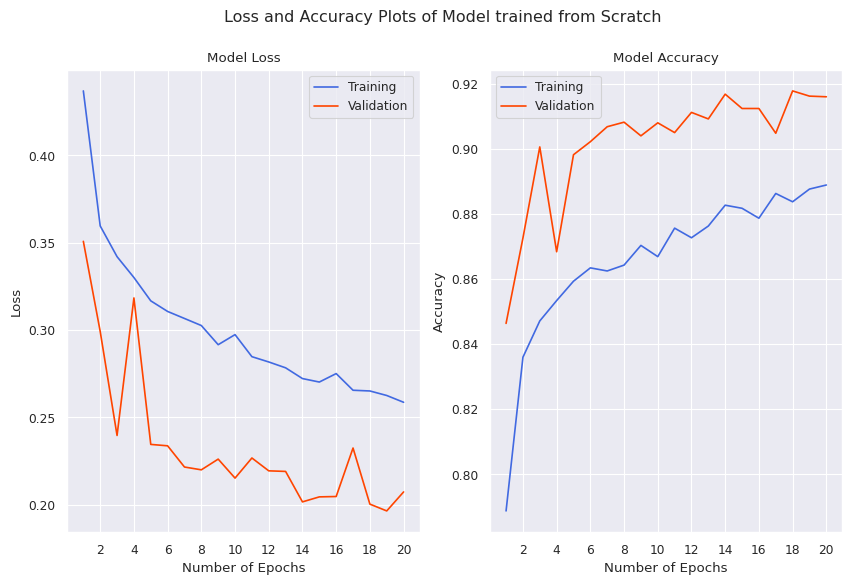

In [ ]:
# Plot model loss and accuracy
fig, axs = plot_loss_accuracy(fs_history)
fig.suptitle('Loss and Accuracy Plots of Model trained from Scratch')
plt.savefig('fs_model.png', dpi=300, bbox_inches='tight')
plt.show()